In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def read_clean_csv(file:object, double_headed = True, x='temperatureC', y='density'):
    """
    Reads and cleans a csv imported from WebPlotDigitilizer

    file: csv file imported from WebPlotDigitilizer.
    double_headed: whether the csv has more two headers
    x: name of the columns that represents the x axis
    y: name of the columns that represents the y axis
    """
    if double_headed:
        df = pd.read_csv(file, header=[0,1])
        new_cols = [list(tup) for tup in df.columns.values]
        for i in range(len(df.columns.values)):
            if i % 2 != 0:
                new_cols[i][0] = new_cols[i-1][0]
                new_cols[i][1] = y
            else:
                new_cols[i][1] = x
        columns = [tuple(lis) for lis in new_cols]
        df.columns = columns
        df.columns = ['_'.join(col) for col in df.columns.values]
        print('Remember to order the columns by density')
    else:
        df = pd.read_csv(file,header=None)
        df.columns = [x,y]
        df = df.sort_values(by=y, axis=0)
        df.reset_index(inplace=True, drop=True)
    return df

In [3]:
def gomez_hotza(Tmax:float, Tinit:float, beta:float, n:float, A: float, Ea: float, theta0: float, G:float, total_time:float, dt:float, R = 8.31446262, beta_SI = False, as_df = False):
    """
    Returns a 2D array with the values of time or temperature and the density or porosity of a material in a sintering process
    
    Tmax: maximum temperature in the process, in °C
    Tinit: initial temperature of process, in °C
    beta: heating rate of the process. Either in °C(K)/min or °C(K)/s
    n: mass transport coefficient, varies from 0.0 to 1.0
    A: Gomez-Hotza preexponent factor
    Ea: material's activation energy, in J/mol
    theta0: initial porosity, dimensionless
    G: mean particle size, in m
    total_time: the total time in the process, in s
    dt: size of each time step, in s
    R: molar gas constant
    beta_SI: wheter the beta value is expressed in °C(K)/s or not
    as_df: if True, the function will return a pandas DataFrame, if False, the function will return a numpy array.
    """

    #Fixed numbers    
    tsteps = int(total_time/dt)
    Tmax += 273
    Tinit += 273
    
    if not beta_SI:
        betaSI = beta/60
    else:
        betaSI = beta
    
    #Initialize arrays
        #Time arrays
    time = np.arange(0, total_time, dt)
    tn = time**(n)
    tc = time
    
        #Temperature arrays
    T = np.ones(tsteps) *Tmax
    T[0] = Tinit
    n1 = np.zeros(tsteps)
    p = -1
    
    for i in range(tsteps):
        T[i] = Tinit + betaSI*time[i]
        n1[i] = np.exp(-Ea/(R*T[i]))
        p += 1

        if T[i] > Tmax:
            T[i] = Tmax
            break #breaks in case the temperature exceeds Tmax, begining of isothermal regime
    p -= 1
    #Porosity and density arrays
    theta = np.zeros(tsteps)
    rho = np.ones(tsteps)
    theta[0] = theta0
    rho[0] = 1 - theta0
    for i in range(p):
        theta[i] = theta0 * np.exp(-(R/Ea) * ((A*n)/G) *n1[i]* tn[i])
        rho[i] = 1 - theta[i]

    #After reaching Tmax temperature
    for i in range(p, tsteps):
        theta[i] = theta[p-1] * np.exp(-(A/G) * np.exp(-Ea/(R*T[p])) * (tn[i] - tn[p-1])/T[p-1])
        rho[i] = 1-theta[i]
    
    results = np.zeros((4, tsteps))
    results[0,:] = tc
    results[1,:] = T
    results[2,:] = rho
    results[3,:] = theta
    
    if as_df:
        results = pd.DataFrame(results.T, columns=['time','temperatureK', 'density', 'porosity'])
        results['time_min'] = results['time']/60
        results['temperatureC'] = results['temperatureK'] - 273
    
    return results   

In [4]:
def validation(df, dfX:object, dfY:object, n_values:list, A_values:list, Ea_values:list,  Tmax:float, Tinit:float, beta:float, theta0:float,G:float,  R = 8.31446262, beta_SI = False):
    """
    Applies a 3D grid search to the gomez_hotza() function.
    
    df: DataFrame with the reference values
    dfX: reference values of x axis, one of ['temperatureK', 'temperatureC', 'time', 'time_min']
    dfY: dfX: reference values of y axis, one of ['density', 'porosity']
    n_values: list of values of n to be tested
    A_values: list of values of A to be tested
    Ea_values: list of values of Ea to be tested
    Tmax: maximum temperature in the process, in °C
    Tinit: initial temperature of process, in °C
    beta: heating rate of the process. Either in °C(K)/min or °C(K)/s
    theta0: initial porosity, dimensionless
    G: mean particle size, in m
    R: molar gas constant
    beta_SI: whether the beta value is expressed in °C(K)/s or not
    """
    validX = ['temperatureK', 'time', 'temperatureC', 'time_min']
    validY = ['density', 'porosity']

    if dfX not in validX:
        raise ValueError('xaxis: must be one of %r.' % validX)
    if dfY not in validY:
        raise ValueError('yaxis: must be one of %r.' % validY)

    if not beta_SI:
        betaSI = beta/60
    else:
        betaSI = beta
    
    total_time = (Tmax - Tinit)/betaSI
    dt = total_time/len(df)
    best_error = float('inf')
    list_of_dictionary = []
    for A in A_values:
        for Ea in Ea_values:
            for n in n_values:
                error_df = pd.DataFrame()
                results = gomez_hotza(Tmax=Tmax, Tinit=Tinit,beta=beta, theta0=theta0, G=G, A=A, Ea=Ea, n=n, total_time=total_time, dt=dt, R=R, beta_SI=beta_SI, as_df=True)
                error_df[dfX] = df[dfX]
                error_df['pred_results'] = results[dfY]
                error_df['ref_results'] = df[dfY].sort_values()
                error_df['squared_error'] = (error_df['pred_results'] - error_df['ref_results']) **2
                error = np.mean(error_df['squared_error'])
                rmse = np.sqrt(error)
                list_of_dictionary.append({'A':A, 'Ea':Ea,'n':n, 'RMSE':rmse})
                if rmse < best_error:
                    best_error = rmse
                    best_params = {'A':A, 'Ea':Ea, 'n':n, 'RMSE':rmse}
                    best = error_df
    data = pd.DataFrame(list_of_dictionary, columns=['A', 'Ea', 'n', 'RMSE'])
    print(f'Best params: {best_params}')
    return best, data  

In [5]:
duran = read_clean_csv("C:/Users/gupau/Documents/UFSC - PC/Semestre 23.2/TCC/Duran/duran.csv", double_headed=False)

In [6]:
predict_duran, params = validation(duran, dfX='temperatureC', dfY='density', n_values=[0.35,0.4,0.45], A_values=[400,550,600], Ea_values=[110e3,210e3,310e3], Tmax=1386.22, Tinit=406.415,beta=5,theta0=0.596372,G=10e-9)
display(predict_duran)
display(params)

Best params: {'A': 600, 'Ea': 210000.0, 'n': 0.45, 'RMSE': 0.2046237006027258}


,temperatureC,pred_results,ref_results,squared_error
0,406.415520,0.403628,0.403628,2.221415e-13
1,559.801603,0.403628,0.405310,2.829308e-06
2,675.883820,0.403628,0.416553,1.670557e-04
3,771.797220,0.403630,0.431607,7.827233e-04
4,856.682085,0.403641,0.467877,4.126275e-03
5,928.509404,0.403700,0.522139,1.402783e-02
6,961.952309,0.403958,0.564715,2.584289e-02
7,986.324226,0.404908,0.610486,4.226204e-02
8,1043.116964,0.407966,0.694967,8.236917e-02
9,1070.565957,0.416664,0.755552,1.148452e-01


,A,Ea,n,RMSE
0,400,110000.0,0.35,0.279293
1,400,110000.0,0.40,0.291993
2,400,110000.0,0.45,0.302802
3,400,210000.0,0.35,0.274790
4,400,210000.0,0.40,0.249313
5,400,210000.0,0.45,0.223154
6,400,310000.0,0.35,0.382425
7,400,310000.0,0.40,0.382336
8,400,310000.0,0.45,0.382182
9,550,110000.0,0.35,0.287656


In [7]:
ytzp = gomez_hotza(Tmax=1386.22, Tinit=406.41, beta=5, n=0.435, A=544.5, Ea=206e3, theta0=0.6, G=10e-9, total_time=2e4, dt=5, as_df= True)


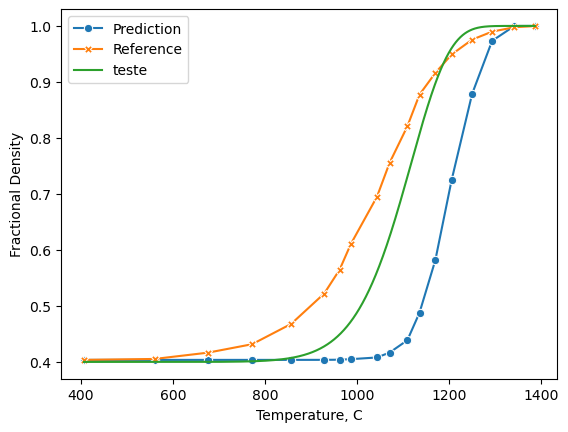

In [8]:
sns.lineplot(data=predict_duran, x='temperatureC', y='pred_results', label='Prediction', marker='o',)
sns.lineplot(data=predict_duran, x='temperatureC', y='ref_results', label='Reference', marker='X')
sns.lineplot(data=ytzp, x='temperatureC', y='density', label='teste')
plt.ylabel('Fractional Density')
plt.xlabel('Temperature, C')
plt.legend()
plt.show()

In [11]:
mazaheri = read_clean_csv("C:/Users/gupau/Documents/UFSC - PC/Semestre 23.2/TCC/Mazaheri/mazaheri.csv", double_headed=True)

Remember to order the columns by density


In [12]:
mazaheri_2K = pd.DataFrame(mazaheri[mazaheri.columns.values[0:2]])
mazaheri_5K = pd.DataFrame(mazaheri[mazaheri.columns.values[2:4]])
mazaheri_20K = pd.DataFrame(mazaheri[mazaheri.columns.values[4:]])

mazaheri_2K.columns = [col[6:] for col in mazaheri_2K.columns.values]
mazaheri_5K.columns = [col[6:] for col in mazaheri_5K.columns.values]
mazaheri_20K.columns = [col[7:] for col in mazaheri_20K.columns.values]

In [37]:
predict_mazaheri2K, params = validation(mazaheri_2K, dfX='temperatureC', dfY='density', n_values=[0.35,0.4,0.45], A_values=[400,550,600], Ea_values=[110e3,210e3,310e3], Tmax=1298.95, Tinit=1068.48,beta=2,theta0=0.543857,G=7.5e-8)
display(predict_mazaheri2K.head())
display(predict_mazaheri2K.tail(6))
ytzp_maza = gomez_hotza(Tmax=1298.95, Tinit=1068.48,beta=2,theta0=0.543857,G=7.5e-8, n=0.435, A=544.5, Ea=206.4e3, total_time=2e4, dt=10, as_df=True,)

Best params: {'A': 600, 'Ea': 210000.0, 'n': 0.45, 'RMSE': 0.11821259119683647}


,temperatureC,pred_results,ref_results,squared_error
0,1064.386429,0.456143,0.456143,2.413747e-13
1,1068.477638,0.460520,0.458205,5.356036e-06
2,1072.568848,0.462408,0.460120,5.235907e-06
3,1076.660057,0.464023,0.461742,5.205723e-06
4,1080.751267,0.465542,0.463510,4.126578e-06


,temperatureC,pred_results,ref_results,squared_error
60,1278.493060,0.706818,0.910891,0.041646
61,1282.584270,0.714858,0.920435,0.042262
62,1286.675479,0.722971,0.928804,0.042367
63,1290.766689,0.731148,0.936588,0.042206
64,1294.857898,0.776940,0.943490,0.027739
65,1298.949108,0.814637,0.949660,0.018231


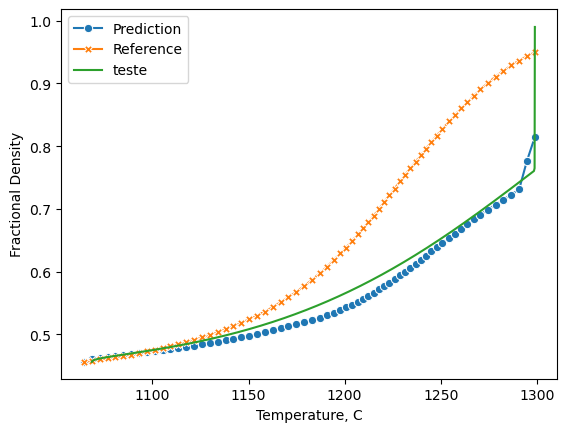

In [38]:
sns.lineplot(data=predict_mazaheri2K, x='temperatureC', y='pred_results', label='Prediction', marker='o',)
sns.lineplot(data=predict_mazaheri2K, x='temperatureC', y='ref_results', label='Reference', marker='X')
sns.lineplot(data=ytzp_maza, x='temperatureC', y='density', label='teste')
plt.ylabel('Fractional Density')
plt.xlabel('Temperature, C')
plt.legend()
plt.show()